# Random Retries Campaign Demonstration

In [5]:
import random
import torch
import numpy as np
from tqdm.auto import trange

from botorch.models import MixedSingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf_mixed
from botorch.acquisition import UpperConfidenceBound

from botorch.models.transforms import Standardize
from botorch.models.transforms.input import Normalize

from typing import List
from categorical_hartmann import CategoricalHartmann

from matplotlib import pyplot as plt
plt.style.use('ggplot')

torch.set_default_dtype(torch.float64)

In [6]:
SEEDS = np.loadtxt('seeds.txt', delimiter=',', dtype=int)

def set_seeds(seed=42):
    """set all library random seeds"""
    seed = int(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def random_sampler(n=2, levels=3, dims=3):
    """Randomly sample the design space."""
    set_seeds(120)
    cont = torch.rand(n, dims, dtype=torch.float64)
    cat = torch.randint(0, levels, (n, 1), dtype=torch.float64)
    # cat = torch.tensor(np.arange(0, 11, 1))[:,None]
    sample = torch.concat([cat, cont], dim=-1)
    return sample

def restarts_optimizer(gp, bounds, levels):
    """Iteratively optimize the acquisition function with different random seeds."""
    X_vals = []
    acqf = []
    for i in SEEDS[:10]:
        set_seeds(i)
        X_new, acq_value = optimize_acqf_mixed(
            acq_function = UpperConfidenceBound(gp, beta=2),
            bounds=bounds,
            fixed_features_list=[{0:i} for i in range(levels)],
            q=1,
            num_restarts=20,
            raw_samples=200,
        )
        X_vals.append(X_new)
        acqf.append(acq_value)
    
    return X_vals[np.argmax(acqf)], acqf


In [10]:
n_init = 5
n_campaigns = 1
budget = 50-n_init

levels = 5 # number of categories
dims = 6 # number of continuous dimensions
CatHart = CategoricalHartmann(levels=levels, dims=dims, noise_std=0.0, seed=10)
print(CatHart)
X_ = random_sampler(n=n_init, levels=levels, dims=dims)
y_ = CatHart(cat=X_[:,0].to(int), X=X_[:,1:])[:,None]

CategoricalHartmann
    Categories = 5
    Continuous Dims = 6
    LevelIntercepts = [1.0, 3.0, 0.0, 1.5, 2.0]
    LevelSlopes = [1.3947368421052633, 1.0789473684210527, 2.026315789473684, 1.1578947368421053, 1.9473684210526314]
    Optimum: CAT 4 | 8.469874534162251


In [11]:
ensemble_y = np.zeros((n_campaigns, n_init+budget))
ensemble_X = np.zeros((n_campaigns, 7, n_init+budget))
ensemble_acqf = np.zeros((n_campaigns, budget))

for i in (pbar0 := trange(n_campaigns, leave=True, colour="red")):
    set_seeds(SEEDS[i]) # set the random seed for the campaign
    X = X_.clone()
    y = y_.clone()

    # iterate through each trial up to budget - n_initial
    for j in (pbar1 := trange(budget, leave=True)):

        # build the gp model
        gp = MixedSingleTaskGP(
            train_X=X,
            train_Y=y,
            cat_dims=[0],
            input_transform = Normalize(d=X.shape[-1], indices=list(np.arange(0, dims, 1)+1)),
            outcome_transform = Standardize(m=y.shape[-1]),
        )

        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        bounds = torch.stack([torch.zeros(dims+1), torch.ones(dims+1)])
        bounds[0,0] = 0.0
        bounds[1,0] = float(levels-1)

        X_new, acqf = restarts_optimizer(gp, bounds, levels)
        set_seeds(SEEDS[i])

        X = torch.cat([X, X_new])
        y = torch.cat([y, CatHart(cat=X_new[:,0].to(int), X=X_new[:,1:])[:,None]])

        pbar0.set_description(f"Processing Trial {j+1} of Campaign {i+1}")
        pbar1.set_description(f"Campaign {i+1} | Best Value {round(torch.max(y).item(),3)}")

    ensemble_y[i,:] = y.flatten()
    ensemble_X[i,:,:] = X.T

Campaign 1 | Best Value 8.237: 100%|██████████| 45/45 [11:49<00:00, 15.76s/it]/s]
Processing Trial 45 of Campaign 1: 100%|██████████| 1/1 [11:49<00:00, 709.40s/it]


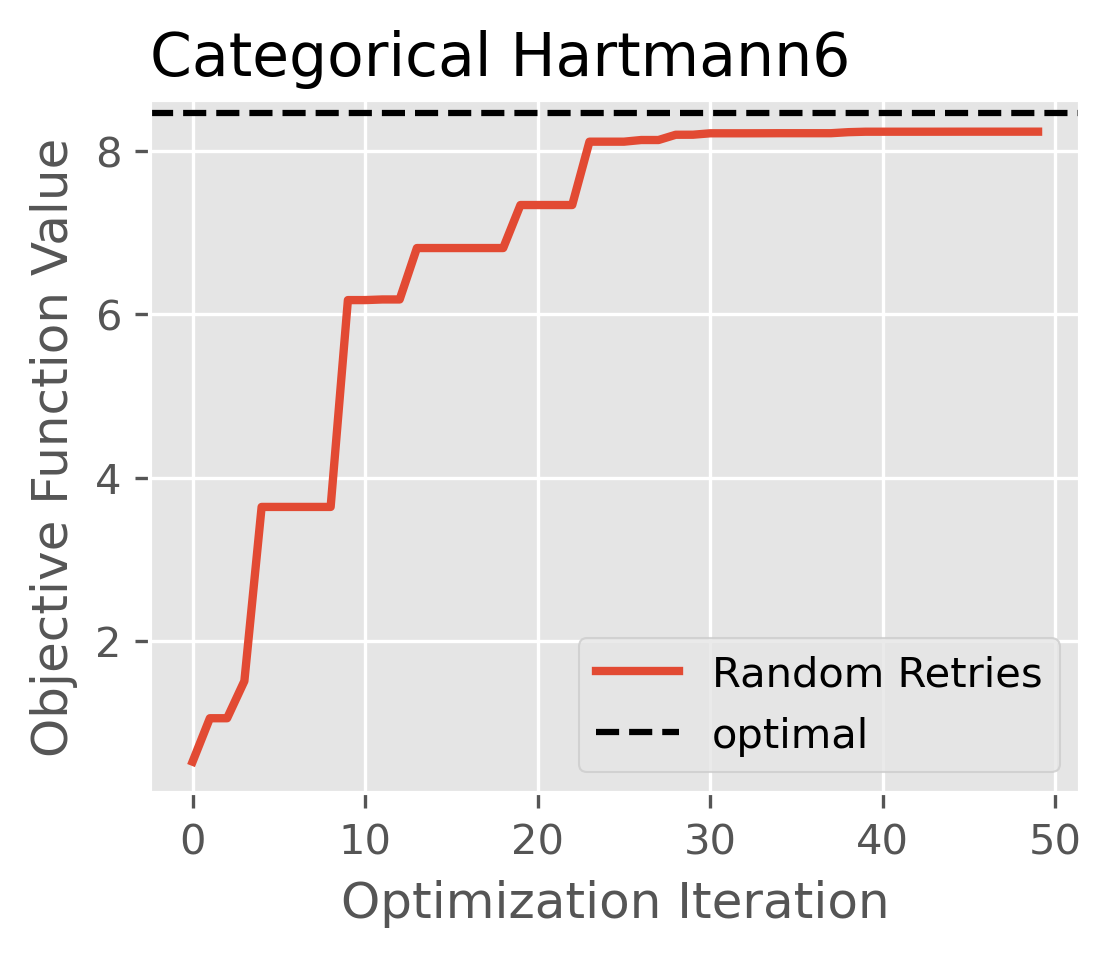

In [12]:
best_to_trial = np.maximum.accumulate(ensemble_y, axis=1)
fig, ax = plt.subplots(figsize=(4,3), dpi=300)
plt.plot(best_to_trial.T, label='Random Retries', lw=2)
plt.axhline(torch.max(CatHart.optima).item(), color='k', ls='--', label='optimal')
plt.xlabel('Optimization Iteration')
plt.ylabel('Objective Function Value')
plt.title("Categorical Hartmann6", loc='left')
plt.legend()
plt.show()